<a href="https://colab.research.google.com/github/yannickfunk/EmbeddedMLLab/blob/main/end2end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import sys

IN_COLAB = False

# if in colab, make colab setup
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    IN_COLAB = True
    ZIP_PATH = "/content/drive/MyDrive/embedded_ml_data/VOCdevkit.zip"
    FILENAME = "inference_examples.ipynb"
    BRANCH = "main"
    !git clone -b $BRANCH https://github.com/yannickfunk/EmbeddedMLLab tmp
    !rm tmp/$FILENAME
    !mv tmp/* .
    !rm -rf tmp
    !rm -rf sample_data
    !pip install -r requirements.txt

    # setup data
    !cp  $ZIP_PATH data/
    %pushd data
    !unzip -qq VOCdevkit.zip
    %popd

In [9]:
import torch
GPU_AVAILABLE = torch.cuda.is_available()
DATA_PATH = "data/"
DOWNLOAD = False

print("Using GPU:", GPU_AVAILABLE)

Using GPU: True


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yfunk/anaconda3/envs/embedded-ml/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/yfunk/anaconda3/envs/embedded-ml/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/yfunk/anaconda3/envs/embedded-ml/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


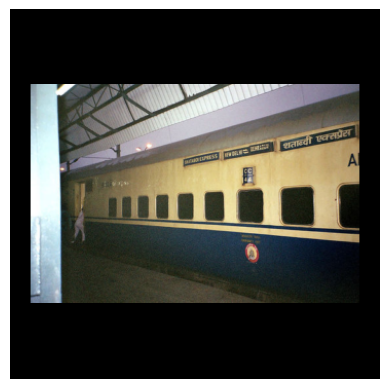

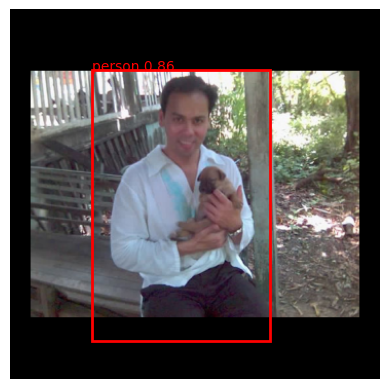

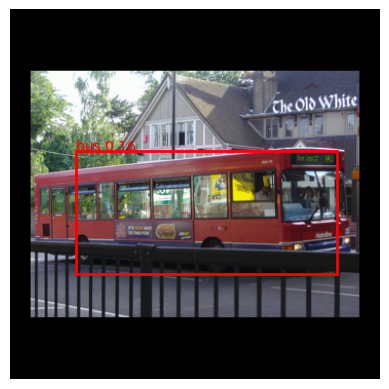

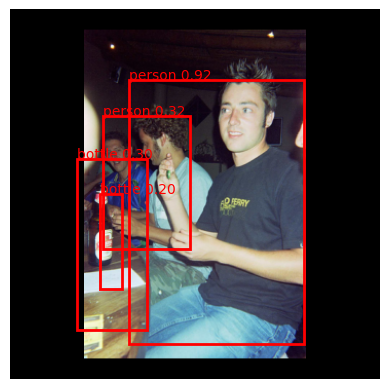

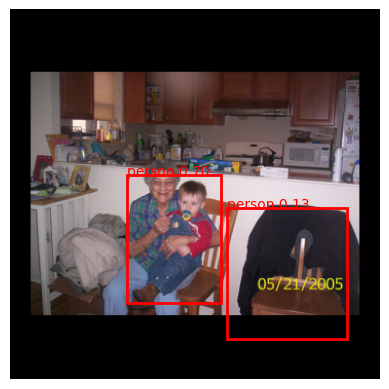

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

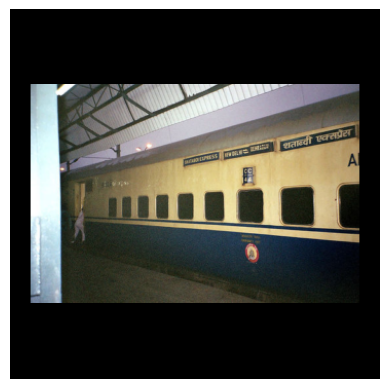

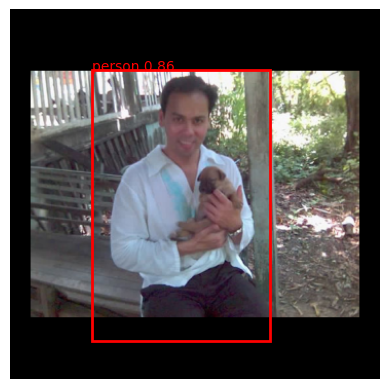

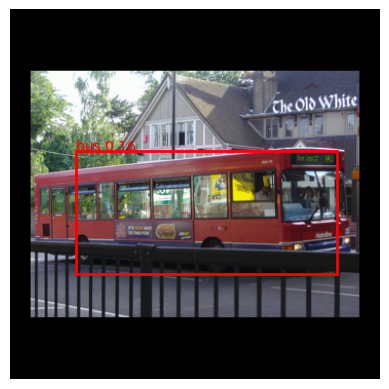

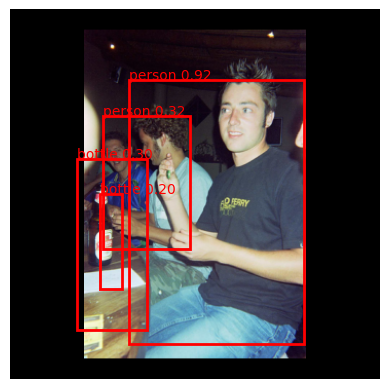

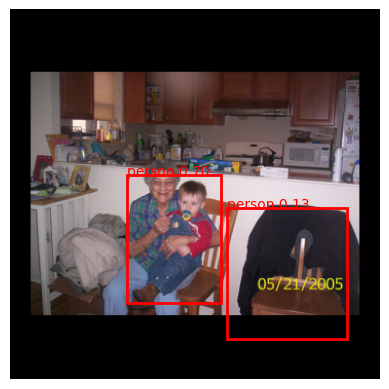

In [10]:
from models.tinyyolov2 import TinyYoloV2Original
from utils.dataloader import VOCDataLoaderPerson
import lightning as pl
from utils.viz import plot_predictions

test_loader = VOCDataLoaderPerson(train=False, batch_size=5, data_path=DATA_PATH, n_limit=5)

model = TinyYoloV2Original()
model.load_pt_from_disk("data/voc_pretrained.pt", discard_last_layer=False)
trainer = pl.Trainer()

predictions = trainer.predict(model, test_loader)[0]
for outputs, inputs, targets in zip(*predictions):
    plot_predictions(outputs, inputs)

In [11]:
# predict on custom image
from PIL import Image
import torchvision.transforms.functional as tf
from utils.dataloader import image_transform

image = Image.open('data/merkel.jpg')
image = image_transform(image)[0]
image = tf.to_tensor(image)
image = torch.unsqueeze(image, 0)

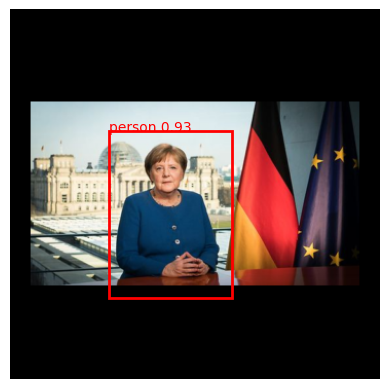

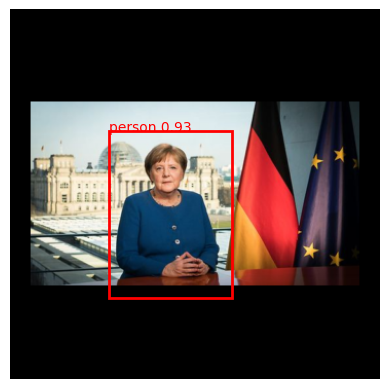

In [12]:
with torch.no_grad():
    predictions = model(image)
    plot_predictions(predictions, image)

In [13]:
# export to onnx
filepath = "data/pretrained.onnx"
input_sample = image
model.to_onnx(filepath, input_sample, export_params=True)

/home/yfunk/repos/EmbeddedMLLab/models/tinyyolov2.py:140: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if yolo:
/home/yfunk/anaconda3/envs/embedded-ml/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/yfunk/anaconda3/envs/embedded-ml/lib/python3.10/site-packages/torch/onnx/utils.py:687: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/pass

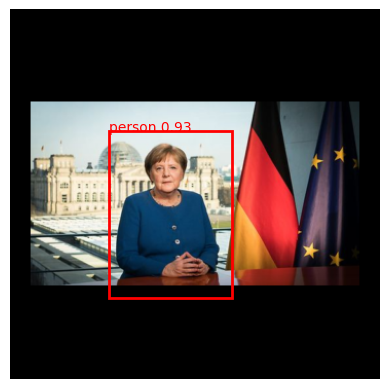

In [15]:
import onnxruntime as ort
from utils.viz import plot_predictions

ort_sess = ort.InferenceSession('data/pretrained.onnx')
onnx_predictions = ort_sess.run(None,  {"input.1": image.numpy()})[0]

# Print Result
plot_predictions(torch.tensor(onnx_predictions), image)